# Multilayer Perceptron

In the previous tutorial we learnt to define a single perceptron model and we trained it to distinguish between two classes of the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

Now we will use the [Keras](https://keras.io/) API to build an artifical neural network (ANN) in its whole, a.k.a the **Multilayer Perceptron** and we'll train it to perform **multi-class classification** on 10 classes.


## From theory...

Recall:
> Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function
$$f: R^d \rightarrow R^o$$
by training on a dataset, where $d$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $t$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers

For example, in one-hidden-layer MLP we learn the following function:

$$f(x) = softmax(b^{(2)} + W^{(2)}(\sigma(b^{(1)} + W^{(1)}x)))$$

where $x$ is the input, $W^{(1)}, b^{(1)}, W^{(2)} b^{(2)}$ are the learned weights and biases for the first and second layer respectively.

## ...to practice

Even if we could implement the whole ANN "by hand", stacking multiple perceptrons together, implemented as we saw in the previous tutorial, we'll make use of the [Keras](https://keras.io/) support for [Dense](https://keras.io/layers/core/#dense) (fully-connected) layers.

### Loading the data

First, we just load the CIFAR-10 data and normalize the training and test images to lie in the range $[0, 1]$. The only thing to note here is that for multi-class classification is often useful to convert the target from scalar values $t \in [0, 1, \dots, nb_{classes}]$ to *one-hot* vectors. For example, suppose we have $C=10$ classes: the target $t_i=3$, indicating that $x_i$ belongs to the class $3$, is converted to the following *one-hot* vector: $[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]$. Being this operation very common, Keras provides a built-in [function](https://keras.io/utils/np_utils/) to do this.

In [1]:
from __future__ import print_function
import numpy as np
from keras.datasets import cifar10
from keras.utils import np_utils

# size of cifar10 images
height, width, channels = 32, 32, 3

nb_classes = 10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = np.reshape(X_train, (len(X_train), height * width * channels))
X_test = np.reshape(X_test, (len(X_test), height * width * channels))
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Using Theano backend.
Using gpu device 0: Quadro K2200 (CNMeM is disabled, cuDNN 5005)


50000 train samples
10000 test samples


### Defining the model (sequential API)

The model we want to build is a MLP with 1 input layer, 2 hidden layers and 1 output layer.

If we follow the syntax of the sequential API, we need to create an instance of `Sequential()` and then stack all the layers one on the top of the other with `model.add(layer)`. Notice that for the first layer we have to specify the input's shape!

Three [`Dense`](https://keras.io/layers/core/#dense) layers are stacked: the first and second have 512 outputs, while the third has as many outputs as the number of classes (10 in our case). The output of the third `Dense` layer is a vector containing `nb_classes` values in an arbitrary range. The `SoftMax` activation squashes these values to the range $[0,1]$, normalizing them such that they sum to $1$ (the math [here](https://en.wikipedia.org/wiki/Softmax_function)). 

Layers of [`Dropout`](https://keras.io/layers/core/#dropout) take a parameter $p \in [0,1]$, which represents the probability to set to 0 a certain input unit at each update during trainig time. As you should know, dropout is a form of regularization which helps prevent overfitting.

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

# sequential model
model = Sequential()
model.add(Dense(512, input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

### Defining the model (functional API)

If we follow the functional API, things are slightly different. We have an `Input` instance which represents the input of the network. Each layer can now be applied just as a function to a certain input and produces a certain output. 

At the end, an instance of `Model` is created and is given the inputs and outputs of the computational graph.

In this simple case there's little difference with the sequential version: however, the functional syntax in general guarantees a huge flexibility in the construction of the network architecture. It's advisable to check the guide to the functional API [here](https://keras.io/getting-started/functional-api-guide/).

In [3]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation

# functional model
model_in = Input(shape=X_train.shape[1:])
x = Dense(512, activation='relu')(model_in)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(10)(x)
model_out = Activation('softmax')(x)

model = Model(input=model_in, output=model_out)

### Everything is right? Doublecheck the summary!
A nice feature of Keras is that we can have access to a text summary of the whole model architecture by simply calling `model.summary()`

In [4]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3072L)         0                                            
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 512)           1573376     input_1[0][0]                    
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 512)           0           dense_4[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 512)           262656      dropout_3[0][0]                  
___________________________________________________________________________________________

As we see, in the summary are reported all information about the computational graph that is going to be compiled. Make sure to understand both the output shape and the number of weights of each layer. 

In order to inspect the **weights** learned by each layer, we can also call the `layer.get_weights()` method. This will return a list with two elements, the first one being the weight tensor and the second one being the bias vector.

In [5]:
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        print('Layer', i, '\t', layer.get_weights()[0].shape, '\t', layer.get_weights()[1].shape)

Layer 1 	 (3072L, 512L) 	 (512L,)
Layer 3 	 (512L, 512L) 	 (512L,)
Layer 5 	 (512L, 10L) 	 (10L,)


Recall that [Dense](https://keras.io/layers/core/#dense) layers  learn a $(n_i, n_o)$ weight tensor, where $n_i$ and $n_o$ area the $n_i$ and output size of the layer respectively. Each of the $n_o$ neurons also has a bias.

### Compiling the model

In order to compile the computational graph, you need to provide at least an optimizer and a loss function. In this case we employ `Adam` as **optimizer**: however, Keras provides a variety of different [bulti-in optimizers](https://keras.io/optimizers/), so feel free to try another one.

Being the task multi-class classification, we unsurprisingly choose as **loss** function the [categorical cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy).

When compiling, we can also feed the model with a list of `metrics` to be evaluated during the training: in this case we measure the `accuracy`.

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Let the training begin!

Now that everything is in place, we are ready to actually start the training of the network. First we set some parameters, in particular the **batch size** is the size of the batch used to perform the gradient descent. Calling `model.fit` will perform `np_epoch` of training on the training set `X_train`.

At the end of each epoch, loss and accuracy are also evaluated on the test data. 

In [9]:
nb_epoch = 20
batch_size = 1024
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 2s - loss: 1.5956 - acc: 0.4308 - val_loss: 1.5311 - val_acc: 0.4498
Epoch 2/20
50000/50000 [==============================] - 2s - loss: 1.5747 - acc: 0.4382 - val_loss: 1.5120 - val_acc: 0.4641
Epoch 3/20
50000/50000 [==============================] - 2s - loss: 1.5566 - acc: 0.4437 - val_loss: 1.4976 - val_acc: 0.4768
Epoch 4/20
50000/50000 [==============================] - 2s - loss: 1.5427 - acc: 0.4514 - val_loss: 1.4903 - val_acc: 0.4787
Epoch 5/20
50000/50000 [==============================] - 2s - loss: 1.5330 - acc: 0.4531 - val_loss: 1.4733 - val_acc: 0.4760
Epoch 6/20
50000/50000 [==============================] - 2s - loss: 1.5179 - acc: 0.4557 - val_loss: 1.4639 - val_acc: 0.4837
Epoch 7/20
50000/50000 [==============================] - 2s - loss: 1.5028 - acc: 0.4626 - val_loss: 1.4426 - val_acc: 0.4932
Epoch 8/20
50000/50000 [==============================] - 2s 

### Evaluation
When the training ends, we can evaluate the generalization performance of the model as follows:

In [10]:
score = model.evaluate(X_test, Y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.38805037575
Test accuracy: 0.5067


The return value of the fit function is a [keras.callbacks.History](https://keras.io/callbacks/#history) object which contains the training/validation loss and accuracy for each epoch.

We can therefore plot the behaviour of loss and accuracy during the training phase.

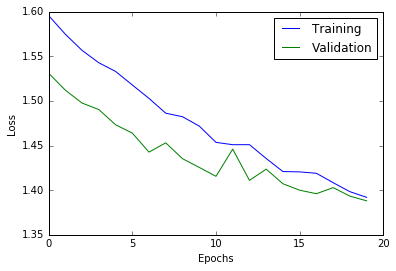

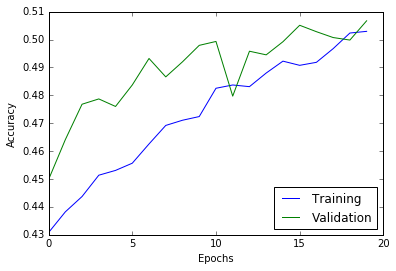

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

### Extra
- What's the problem of this model? Anything to do with over/underfitting?